In [16]:
import clip
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2 as cv

from segment_track.fastsam_wrapper import FastSAMWrapper

from robotdatapy.data.img_data import ImgData

In [17]:
device = 'cuda'

# clip_model, preprocess = clip.load('ViT-B/32', device=device)
clip_model, preprocess = clip.load('ViT-L/14', device=device)



In [18]:
fastsam = FastSAMWrapper(
    weights=os.path.expandvars("$FASTSAM_WEIGHTS")
)

In [19]:
img_data = ImgData.from_bag(
    path="/media/masonbp/T71/data/2024_07_highbay_overhead/exp2/runA1a.bag",
    topic="/RR08/l515/color/image_raw/compressed",
    compressed=True
)

True

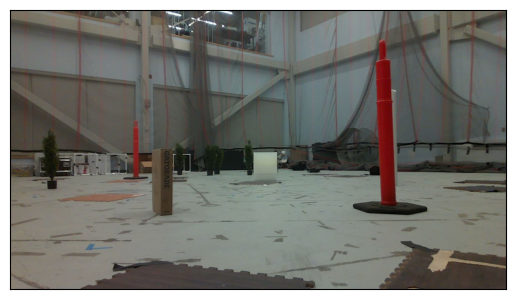

In [20]:
img = img_data.img(img_data.t0)
img_data.show(img_data.t0)
cv.imwrite("/home/masonbp/dcist/segment_track/local/notebooks/test.png", img)
# img_data.show(img_data.t0 + 100)

In [31]:
good_pil = []
bad_pil = []

img = img_data.img(img_data.t0)
pils = fastsam._process_img(img[...,::-1])

# show each PIL image
# for i, pil in enumerate(pils):
#     plt.imshow(pil)
#     plt.title(i)
#     plt.show()
    
# good_pil.append(pils[2])
# good_pil.append(pils[13])
# bad_pil.append(pils[5])
# bad_pil.append(pils[21])

good_pil.append(pils[3])
good_pil.append(pils[12])
bad_pil.append(pils[0])


0: 576x1024 31 objects, 62.2ms
Speed: 2.6ms preprocess, 62.2ms inference, 3.7ms postprocess per image at shape (1, 3, 1024, 1024)


In [32]:
img = img_data.img(img_data.t0 + 4.5)
pils = fastsam._process_img(img[...,::-1])

# show each PIL image
# for i, pil in enumerate(pils):
#     plt.imshow(pil)
#     plt.title(i)
#     plt.show()
    
# good_pil.append(pils[4])

good_pil.append(pils[3])
bad_pil.append(pils[18])


0: 576x1024 32 objects, 53.0ms
Speed: 2.4ms preprocess, 53.0ms inference, 3.7ms postprocess per image at shape (1, 3, 1024, 1024)


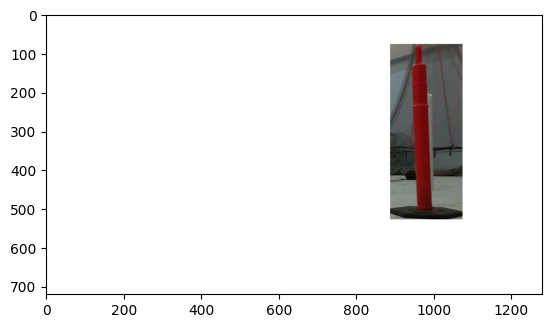

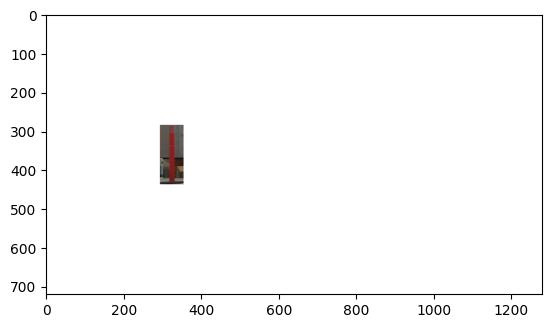

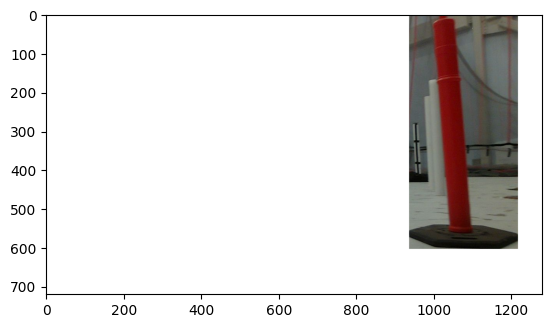

In [33]:
for gp in good_pil:
    # show each PIL image
    plt.imshow(gp)
    plt.show()

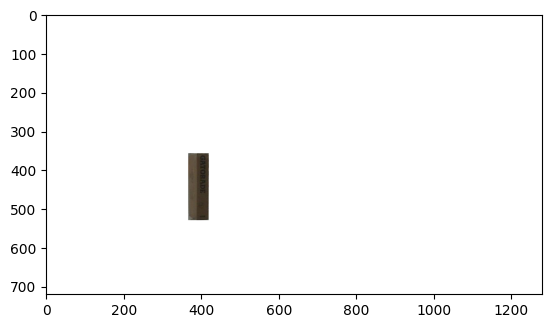

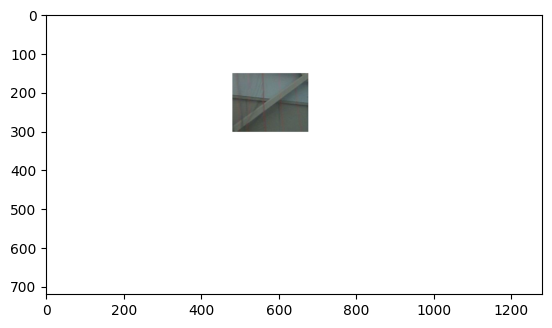

In [34]:
for bp in bad_pil:
    # show each PIL image
    plt.imshow(bp)
    plt.show()

In [35]:
good_features = []
bad_features = []

for i, pil in enumerate(good_pil + bad_pil):
    pre_processed_img = preprocess(pil).to(device)
    stacked_images = torch.stack([pre_processed_img])
    image_features = clip_model.encode_image(stacked_images)
    
    if i < len(good_pil):
        good_features.append(image_features[0].cpu().detach().numpy())
    else:
        bad_features.append(image_features[0].cpu().detach().numpy())

In [42]:
print(np.linalg.norm(good_features[0]))
print(np.round(good_features[0][20:40] / np.linalg.norm(good_features[0]), 2))
print(np.round(bad_features[1][20:40] / np.linalg.norm(good_features[1]), 2))

20.42
[  -0.010002    0.010002   -0.020004           0   -0.070007    0.029999    0.010002    0.010002    0.029999   -0.029999           0    0.010002   -0.020004    0.020004   -0.010002   -0.010002    0.010002          -0    0.010002   -0.020004]
[   0.020004    0.020004   -0.049988          -0   -0.020004           0          -0   -0.029999    0.040009    0.010002   -0.010002          -0   -0.040009   -0.010002    0.020004          -0   -0.010002   -0.010002   -0.010002          -0]


In [37]:
for gf1 in good_features:
    for gf2 in good_features:
        if gf1 is gf2:
            continue
        print(np.dot(gf1, gf2)/(np.linalg.norm(gf1)*np.linalg.norm(gf2)))
# cosine_similarity = torch.nn.functional.cosine_similarity(image_features, image_features_2)


0.8906
0.936
0.8906
0.9014
0.936
0.9014


In [38]:
for gf in good_features:
    for bf in bad_features:
        print(np.dot(gf1, bf)/(np.linalg.norm(gf1)*np.linalg.norm(bf)))

0.864
0.816
0.864
0.816
0.864
0.816


In [39]:
tokenized_text = clip.tokenize(["traffic cone"]).to(device)
good_text_features = clip_model.encode_text(tokenized_text)[0].cpu().detach().numpy()

tokenized_text = clip.tokenize(["an alligator"]).to(device)
bad_text_features = clip_model.encode_text(tokenized_text)[0].cpu().detach().numpy()

In [40]:
for gf in good_features:
    print(np.dot(gf, good_text_features)/(np.linalg.norm(gf)*np.linalg.norm(good_text_features)))
print()
for gf in good_features:
    print(np.dot(gf, bad_text_features)/(np.linalg.norm(gf)*np.linalg.norm(bad_text_features)))

0.1998
0.1876
0.1757

0.153
0.1631
0.1533
